In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
import itertools
from keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Convolution2D as Conv2D
from keras.layers import MaxPool2D
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import lightgbm
from keras import optimizers
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import skimage.io
from skimage.io import imread
import pprint, pickle

Using TensorFlow backend.


In [2]:
# imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
#                      for x in glob(os.path.join(os.path.join('..', 'cancer_classifier'), '*', '*.jpg'))}

In [3]:
# len(imageid_path_dict)

In [4]:
# lesions = {
#     'nv': 'Melanocytic nevi',
#     'mel': 'dermatofibroma',
#     'bkl': 'Benign keratosis-like lesions ',
#     'bcc': 'Basal cell carcinoma',
#     'akiec': 'Actinic keratoses',
#     'vasc': 'Vascular lesions',
#     'df': 'Dermatofibroma'
# }

In [5]:
# df = pd.read_csv(os.path.join(os.path.join('..', 'cancer_classifier'), 'HAM10000_metadata.csv')) #links image csv with main path
# df['path'] = df['image_id'].map(imageid_path_dict.get) #links image path with df
# df['cell_type'] = df['dx'].map(lesions.get) #combines with dictionary
# df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes #converts the lession types to categorical

In [6]:
# df

In [7]:
# df.columns

In [8]:
# df.dtypes

In [9]:
# df['age'].fillna((df['age'].mean()), inplace=True) #replace all null age with mean of population age
# df.isnull().sum()

In [2]:
# df.to_csv('2cancercell.csv', index=False)
df= pd.read_csv('2cancercell.csv')
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../cancer_classifier/HAM10000_images_part_2/IS...,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0


In [11]:
df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0003789,ISIC_0033044,nv,histo,male,back,../cancer_classifier/HAM10000_images_part_1/IS...,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


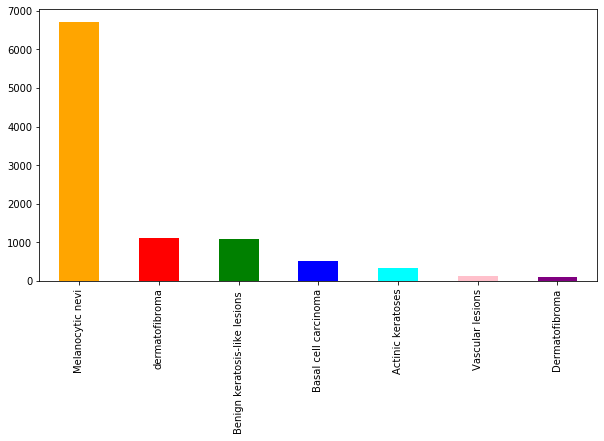

In [12]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
df['cell_type'].value_counts().plot(kind='bar', color=['orange', 'red', 'green', 'blue', 'cyan', 'pink', 'purple'])

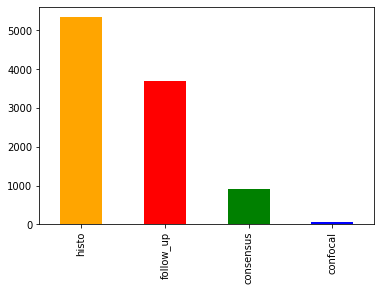

In [13]:
df['dx_type'].value_counts().plot(kind='bar', color=['orange', 'red', 'green', 'blue'])

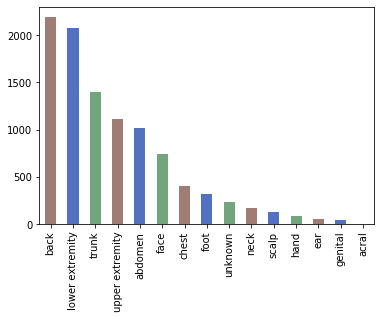

In [14]:
df['localization'].value_counts().plot(kind='bar', color=np.random.rand(3,4))

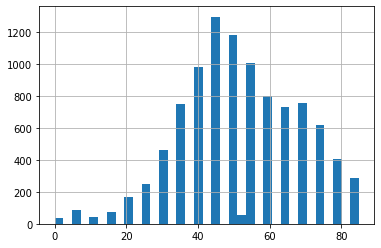

In [15]:
df['age'].hist(bins=35)

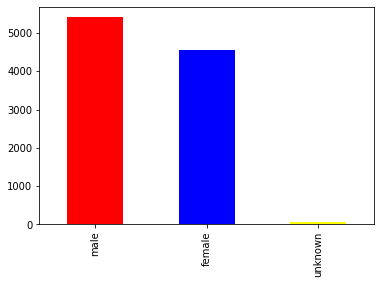

In [16]:
df['sex'].value_counts().plot(kind='bar', color=['red', 'blue', 'yellow'])

In [3]:
#change shape so tensorflow can handle the images
df['images']= df['path'].map((lambda x: np.asarray(Image.open(x).resize((100,75)))))
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,images
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../cancer_classifier/HAM10000_images_part_2/IS...,Benign keratosis-like lesions,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0,"[[[172, 155, 165], [170, 148, 160], [153, 139,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0,"[[[6, 6, 4], [7, 8, 3], [7, 9, 8], [9, 8, 6], ..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0,"[[[114, 106, 104], [127, 121, 121], [140, 128,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0,"[[[159, 125, 149], [158, 125, 142], [152, 107,..."


In [18]:
df['images']

0        [[[191, 153, 194], [191, 154, 198], [189, 152,...
1        [[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3...
2        [[[186, 126, 136], [190, 136, 149], [195, 137,...
3        [[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6...
4        [[[136, 91, 114], [148, 104, 127], [161, 117, ...
                               ...                        
10010    [[[172, 155, 165], [170, 148, 160], [153, 139,...
10011    [[[6, 6, 4], [7, 8, 3], [7, 9, 8], [9, 8, 6], ...
10012    [[[114, 106, 104], [127, 121, 121], [140, 128,...
10013    [[[159, 125, 149], [158, 125, 142], [152, 107,...
10014    [[[180, 152, 141], [174, 142, 131], [179, 147,...
Name: images, Length: 10015, dtype: object

In [19]:
# n_samples = 5
# fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
# for n_axs, (type_name, type_rows) in zip(m_axs, 
#                                          df.sort_values(['cell_type']).groupby('cell_type')):
#     n_axs[0].set_title(type_name)
#     for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
#         c_ax.imshow(c_row['images'])
#         c_ax.axis('off')
# fig.savefig('category_samples.png', dpi=300)

In [20]:
df['images'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: images, dtype: int64

In [21]:
#save the df with images into a pickle
# output = open('df-image.pkl', 'wb') #write a file larger than 4 gb
# pickle.dump(df, output, protocol=4)
# output.close()

In [22]:
#to read the file:
pkl_file = open('df-image.pkl', 'rb') #read

df = pickle.load(pkl_file)

pkl_file.close()

In [23]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,images
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../cancer_classifier/HAM10000_images_part_2/IS...,Benign keratosis-like lesions,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."


In [24]:
df.dtypes

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx      int64
images            object
dtype: object

In [4]:
df= df.drop(['lesion_id', 'image_id', 'path'], axis=1)
df

,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,images
0,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."
...,...,...,...,...,...,...,...,...
10010,akiec,histo,40.0,male,abdomen,Actinic keratoses,0,"[[[172, 155, 165], [170, 148, 160], [153, 139,..."
10011,akiec,histo,40.0,male,abdomen,Actinic keratoses,0,"[[[6, 6, 4], [7, 8, 3], [7, 9, 8], [9, 8, 6], ..."
10012,akiec,histo,40.0,male,abdomen,Actinic keratoses,0,"[[[114, 106, 104], [127, 121, 121], [140, 128,..."
10013,akiec,histo,80.0,male,face,Actinic keratoses,0,"[[[159, 125, 149], [158, 125, 142], [152, 107,..."


In [5]:
#dummy encoding thanks to stackflow
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)

In [6]:
df=encode_and_bind(df, 'dx')
df= encode_and_bind(df, 'dx_type')
df=encode_and_bind(df, 'sex')
df=encode_and_bind(df, 'localization')
df=encode_and_bind(df, 'cell_type')
df.head()

,age,cell_type_idx,images,dx_akiec,dx_bcc,dx_bkl,dx_df,dx_mel,dx_nv,dx_vasc,...,localization_trunk,localization_unknown,localization_upper extremity,cell_type_Actinic keratoses,cell_type_Basal cell carcinoma,cell_type_Benign keratosis-like lesions,cell_type_Dermatofibroma,cell_type_Melanocytic nevi,cell_type_Vascular lesions,cell_type_dermatofibroma
0,80.0,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,...",0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,80.0,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3...",0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,80.0,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,...",0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,80.0,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6...",0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,75.0,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ...",0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [7]:
df.dtypes

age                                         float64
cell_type_idx                                 int64
images                                       object
dx_akiec                                      uint8
dx_bcc                                        uint8
dx_bkl                                        uint8
dx_df                                         uint8
dx_mel                                        uint8
dx_nv                                         uint8
dx_vasc                                       uint8
dx_type_confocal                              uint8
dx_type_consensus                             uint8
dx_type_follow_up                             uint8
dx_type_histo                                 uint8
sex_female                                    uint8
sex_male                                      uint8
sex_unknown                                   uint8
localization_abdomen                          uint8
localization_acral                            uint8
localization

In [8]:
features= df.drop(['cell_type_idx'], axis=1)
target= df['cell_type_idx']

In [9]:
print(features.shape)
print(target.shape)

(10015, 38)
(10015,)


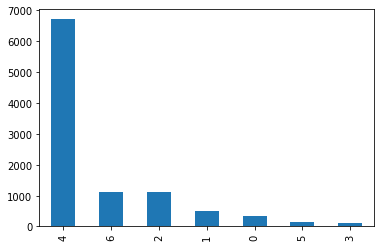

In [10]:
target.value_counts().plot(kind='bar')

In [11]:
#train test split
feature_train, feature_test, target_train, target_test= train_test_split(
    features, target, test_size=0.30, random_state=444)

In [12]:
target_train

9552    4
4820    4
9341    4
9895    0
9381    4
       ..
6631    4
948     2
3336    4
8983    4
7555    4
Name: cell_type_idx, Length: 7010, dtype: int64

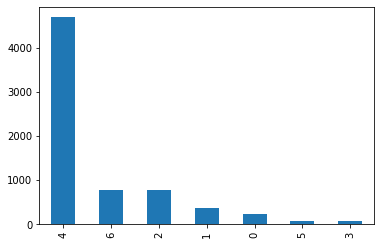

In [13]:
target_train.value_counts().plot(kind='bar')

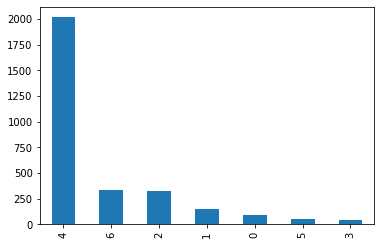

In [14]:
target_test.value_counts().plot(kind='bar')

In [15]:
# Perform one-hot encoding on the labels
target_train = to_categorical(target_train, num_classes = 7)
target_test = to_categorical(target_test, num_classes = 7)

In [16]:
target_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [17]:
print('total feature training features: ', len(feature_train))
print('total feature testing features: ', len(feature_test))
print('total target training features: ', len(target_train))
print('total target testing features: ', len(target_test))
print('feature train shape: ', feature_train.shape)
print('feature test shape: ', feature_test.shape)
print('train train shape: ', target_train.shape)
print('train test shape: ', target_test.shape)

total feature training features:  7010
total feature testing features:  3005
total target training features:  7010
total target testing features:  3005
feature train shape:  (7010, 38)
feature test shape:  (3005, 38)
train train shape:  (7010, 7)
train test shape:  (3005, 7)


In [18]:
#standardize the pictures
x_train = np.asarray(feature_train['images'].tolist())
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
feature_train = (x_train - x_train_mean)/x_train_std

In [19]:
x_test = np.asarray(feature_test['images'].tolist())
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)
feature_test = (x_test - x_test_mean)/x_test_std

In [20]:
feature_train.shape

(7010, 75, 100, 3)

In [21]:
feature_test.shape

(3005, 75, 100, 3)

In [22]:
input_shape = (75, 100, 3)
num_classes = 7

In [23]:
optimizer= keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [24]:
data= ImageDataGenerator(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  height_shift_range = 0.1, 
                  zoom_range = [0.5, 1.50],  
                  horizontal_flip = True, 
                  vertical_flip = True)

data.fit(x_train)  

In [25]:
# Set a learning rate annealer
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', #checks validation accuracy
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.3, 
                                            min_lr=0.0001)

In [26]:
model= Sequential()
model.add(Convolution2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(.3))

model.add(Convolution2D(64,(3,3), input_shape=input_shape, activation='relu'))
model.add(Convolution2D(64,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(64,(3,3), input_shape=input_shape, activation='relu'))
model.add(Convolution2D(64,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [27]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=[['accuracy', 'mse']])

In [28]:
batch_size = 50
epochs = 15

history = model.fit(feature_train, target_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(feature_test, target_test),
                   callbacks=[lr_reduction])

score = model.evaluate(feature_test, target_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7010 samples, validate on 3005 samples
Epoch 1/15
7010/7010 [==============================] - 77s 11ms/step - loss: 1.0864 - accuracy: 0.6606 - mse: 0.0715 - val_loss: 1.4894 - val_accuracy: 0.6715 - val_mse: 0.0991
Epoch 2/15
7010/7010 [==============================] - 74s 11ms/step - loss: 0.9577 - accuracy: 0.6679 - mse: 0.0648 - val_loss: 0.9402 - val_accuracy: 0.6849 - val_mse: 0.0622
Epoch 3/15
7010/7010 [==============================] - 73s 10ms/step - loss: 0.8968 - accuracy: 0.6803 - mse: 0.0617 - val_loss: 0.8638 - val_accuracy: 0.6915 - val_mse: 0.0581
Epoch 4/15
7010/7010 [==============================] - 74s 11ms/step - loss: 0.8531 - accuracy: 0.6917 - mse: 0.0587 - val_loss: 0.8868 - val_accuracy: 0.6862 - val_mse: 0.0612
Epoch 5/15
7010/7010 [==============================] - 75s 11ms/step - loss: 0.8358 - accuracy: 0.7007 - mse: 0.0581 - val_loss: 0.8223 - val_accuracy: 0.7028 - val_mse: 0.0564
Epoch 6/15
7010/7010 [==============================] - 75s 11

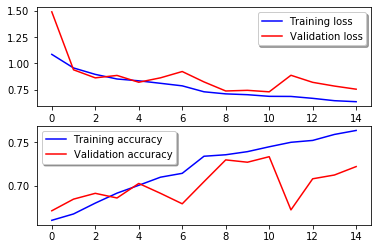

In [29]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

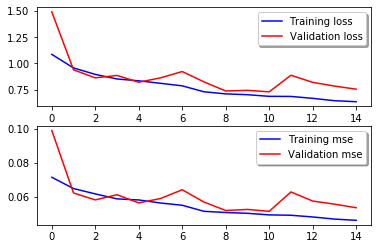

In [30]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['mse'], color='b', label="Training mse")
ax[1].plot(history.history['val_mse'], color='r',label="Validation mse")
legend = ax[1].legend(loc='best', shadow=True)

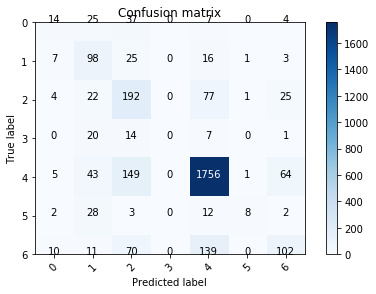

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(feature_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(target_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

In [41]:
#second model
model= Sequential()
model.add(Convolution2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(.3))
model.add(Convolution2D(64,(3,3), input_shape=input_shape, activation='relu'))
model.add(Convolution2D(64,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(64,(3,3), input_shape=input_shape, activation='relu'))
model.add(Convolution2D(64,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [42]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=[['accuracy', 'mse']])

In [43]:
epochs = 15 
batch_size = 10
history = model.fit(feature_train, target_train,
                    batch_size=batch_size,
                    epochs=epochs,verbose=1,
                    validation_data=(feature_test, target_test),
                   callbacks=[lr_reduction])

score = model.evaluate(feature_test, target_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7010 samples, validate on 3005 samples
Epoch 1/15
7010/7010 [==============================] - 100s 14ms/step - loss: 1.0129 - accuracy: 0.6683 - mse: 0.0674 - val_loss: 0.9021 - val_accuracy: 0.6885 - val_mse: 0.0609
Epoch 2/15
7010/7010 [==============================] - 101s 14ms/step - loss: 0.8863 - accuracy: 0.6870 - mse: 0.0598 - val_loss: 0.8749 - val_accuracy: 0.7038 - val_mse: 0.0595
Epoch 3/15
7010/7010 [==============================] - 102s 15ms/step - loss: 0.8514 - accuracy: 0.6922 - mse: 0.0584 - val_loss: 0.8085 - val_accuracy: 0.7078 - val_mse: 0.0557
Epoch 4/15
7010/7010 [==============================] - 104s 15ms/step - loss: 0.8350 - accuracy: 0.7029 - mse: 0.0569 - val_loss: 0.8295 - val_accuracy: 0.7032 - val_mse: 0.0572
Epoch 5/15
7010/7010 [==============================] - 105s 15ms/step - loss: 0.8153 - accuracy: 0.7108 - mse: 0.0559 - val_loss: 0.8093 - val_accuracy: 0.7101 - val_mse: 0.0561
Epoch 6/15
7010/7010 [==============================] - 1

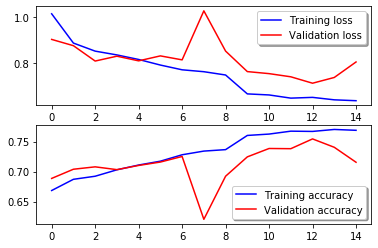

In [44]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

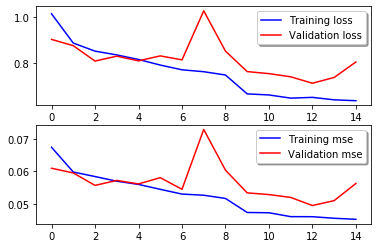

In [45]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['mse'], color='b', label="Training mse")
ax[1].plot(history.history['val_mse'], color='r',label="Validation mse")
legend = ax[1].legend(loc='best', shadow=True)

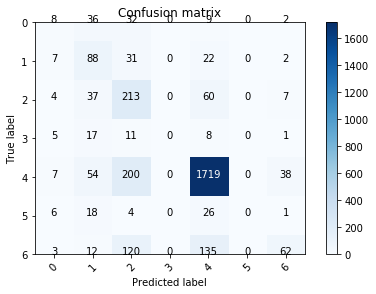

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(feature_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(target_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

The best matrix I have seen so far. I will attempt to improve this through perhaps transfer learning. If that fails, then I would have to create a smaller dense layer as I think that may be the issue

These needs to be more complex as I believe that it is just not being trained enough and converging as it is out of training parameters.

In [47]:
epochs = 15 
batch_size = 10
#a simpler model with less hidden networks and leakyrelu based on animal image classification
model = Sequential()  
model.add(Flatten(input_shape=input_shape))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.3)) 
model.add(Dense(75, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=[['accuracy', 'mse']])  

history = model.fit(feature_train, target_train,
                    batch_size=batch_size,
                    epochs=epochs,verbose=1,
                    validation_data=(feature_test, target_test),
                   callbacks=[lr_reduction])

score = model.evaluate(feature_test, target_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7010 samples, validate on 3005 samples
Epoch 1/15
7010/7010 [==============================] - 14s 2ms/step - loss: 3.7913 - accuracy: 0.5190 - mse: 0.1145 - val_loss: 1.4020 - val_accuracy: 0.5151 - val_mse: 0.0927
Epoch 2/15
7010/7010 [==============================] - 13s 2ms/step - loss: 1.9107 - accuracy: 0.5673 - mse: 0.0940 - val_loss: 1.2299 - val_accuracy: 0.6423 - val_mse: 0.0815
Epoch 3/15
7010/7010 [==============================] - 13s 2ms/step - loss: 1.5349 - accuracy: 0.5990 - mse: 0.0849 - val_loss: 1.2669 - val_accuracy: 0.6343 - val_mse: 0.0864
Epoch 4/15
7010/7010 [==============================] - 13s 2ms/step - loss: 1.3358 - accuracy: 0.6265 - mse: 0.0795 - val_loss: 1.0097 - val_accuracy: 0.6752 - val_mse: 0.0655
Epoch 5/15
7010/7010 [==============================] - 13s 2ms/step - loss: 1.2229 - accuracy: 0.6434 - mse: 0.0747 - val_loss: 1.0950 - val_accuracy: 0.6725 - val_mse: 0.0711
Epoch 6/15
7010/7010 [==============================] - 14s 2ms/ste

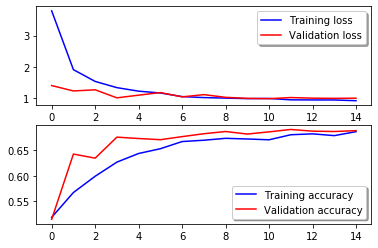

In [48]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

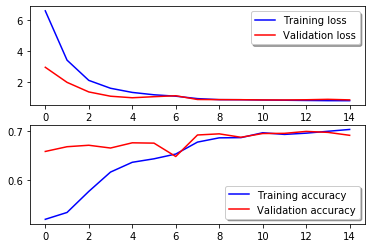

In [61]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

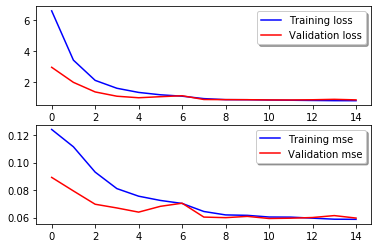

In [62]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['mse'], color='b', label="Training mse")
ax[1].plot(history.history['val_mse'], color='r',label="Validation mse")
legend = ax[1].legend(loc='best', shadow=True)

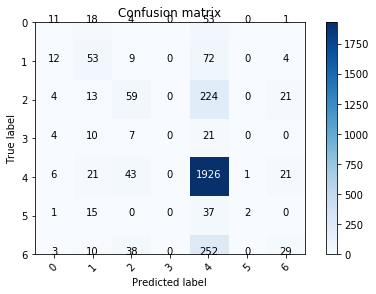

In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(feature_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(target_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

Better than ReLu but worse than the model I have made previously.

In [64]:
epochs = 15 
batch_size = 10
#this model is from my animal image classifier but with relu
model = Sequential()  
model.add(Flatten(input_shape=input_shape))
model.add(Dense(100, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation='relu')) 
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=[['accuracy', 'mse']])  

history = model.fit(feature_train, target_train,
                    batch_size=batch_size,
                    epochs=epochs,verbose=1,
                    validation_data=(feature_test, target_test),
                   callbacks=[lr_reduction])

Train on 7010 samples, validate on 3005 samples
Epoch 1/15
7010/7010 [==============================] - 12s 2ms/step - loss: 2.3865 - accuracy: 0.6116 - mse: 0.0952 - val_loss: 1.1762 - val_accuracy: 0.6702 - val_mse: 0.0751
Epoch 2/15
7010/7010 [==============================] - 12s 2ms/step - loss: 1.3025 - accuracy: 0.6603 - mse: 0.0781 - val_loss: 1.1561 - val_accuracy: 0.6699 - val_mse: 0.0745
Epoch 3/15
7010/7010 [==============================] - 13s 2ms/step - loss: 1.2049 - accuracy: 0.6666 - mse: 0.0764 - val_loss: 1.2093 - val_accuracy: 0.6709 - val_mse: 0.0757
Epoch 4/15
7010/7010 [==============================] - 15s 2ms/step - loss: 1.1780 - accuracy: 0.6665 - mse: 0.0761 - val_loss: 1.1538 - val_accuracy: 0.6725 - val_mse: 0.0744
Epoch 5/15
7010/7010 [==============================] - 12s 2ms/step - loss: 1.2152 - accuracy: 0.6673 - mse: 0.0762 - val_loss: 1.1657 - val_accuracy: 0.6712 - val_mse: 0.0748
Epoch 6/15
7010/7010 [==============================] - 12s 2ms/ste

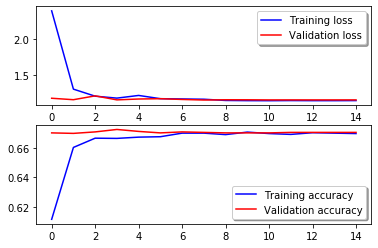

In [65]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

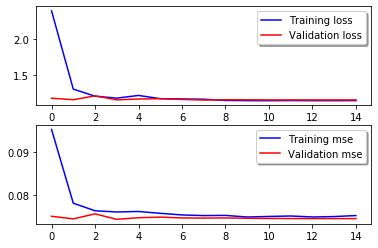

In [66]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['mse'], color='b', label="Training mse")
ax[1].plot(history.history['val_mse'], color='r',label="Validation mse")
legend = ax[1].legend(loc='best', shadow=True)

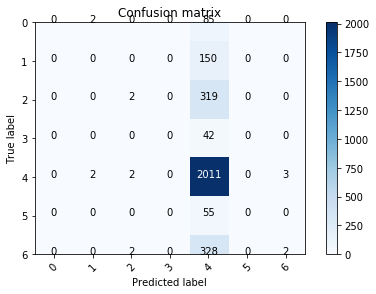

In [67]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(feature_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(target_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

Confusion Matrix failed to predict properly, even with high accuarcy. Showing cases of misidentification and possible overfitting.